In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

sys.path.append("../src")
import localmodule

In [3]:
models_dir = localmodule.get_models_dir()
model_name = "SKM"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)

unit_relevant = []
unit_selected, unit_tp = [], []
best_selected, best_tp = [], []
for unit_str in units:
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([model_name, tol_str, unit_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    thresholds = np.array(df["threshold"])
    f1_scores = np.array(df["F1 score (%)"])
    best_id = np.argmax(f1_scores)
    best_threshold = thresholds[best_id]
    best_precision = np.array(df["precision (%)"])[best_id]
    best_recall = np.array(df["recall (%)"])[best_id]
    best_f1 = np.array(df["F1 score (%)"])[best_id]
    print(unit_str +
          ": oracle threshold = " + ("%0.3f" % best_threshold).rjust(5) + 
          ", P = " + ("%0.2f" % best_precision).rjust(5) + "%" + 
          ", R = " + ("%0.2f" % best_recall).rjust(5) + "%" + 
          ", F = " + ("%0.2f" % best_f1).rjust(5) + "%")
    unit_relevant.append(np.array(df["relevant"])[0])
    unit_selected.append(np.array(df["selected"]))
    unit_tp.append(np.array(df["true positives"]))
    best_selected.append(np.array(df["selected"])[best_id])
    best_tp.append(np.array(df["true positives"])[best_id])


global_relevant = np.sum(np.array(unit_relevant))
global_best_selected = np.sum(np.array(best_selected))
global_best_tp = np.sum(np.array(best_tp))
global_best_pre = 100 * global_best_tp / global_best_selected
global_best_rec = 100 * global_best_tp / global_relevant
global_best_f1 = 2 * global_best_pre * global_best_rec / (global_best_pre + global_best_rec)

print("")    
print("Global (oracle): ")
print("Relevant = " + str(global_relevant))
print("Selected = " + str(global_best_selected))
print("True positives = " + str(global_best_tp))
print("Precision = " + ("%0.2f" % global_best_pre).rjust(5) + "%")
print("Recall = " + ("%0.2f" % global_best_rec).rjust(5) + "%")
print("F1 score = " + ("%0.2f" % global_best_f1).rjust(5) + "%")

unit01: oracle threshold = 0.779, P = 72.59%, R = 59.91%, F = 65.64%
unit02: oracle threshold = 0.709, P =  4.54%, R = 17.99%, F =  7.25%
unit03: oracle threshold = 0.688, P =  8.89%, R = 19.68%, F = 12.25%
unit05: oracle threshold = 0.692, P =  4.83%, R = 24.39%, F =  8.06%
unit07: oracle threshold = 0.655, P =  7.55%, R = 39.42%, F = 12.67%
unit10: oracle threshold = 0.679, P = 18.04%, R = 23.40%, F = 20.37%

Global (oracle): 
Relevant = 35402
Selected = 110871
True positives = 9855
Precision =  8.89%
Recall = 27.84%
F1 score = 13.47%


In [5]:
folds = localmodule.fold_units()
unit_relevant = []
best_selected, best_tp = [], []
%matplotlib inline

for fold in folds:
    test_units = fold[0]
    training_units = fold[1]
    validation_units = fold[2]
    calibration_units = fold[1] + fold[2]
    cal_relevant = []
    cal_selected = []
    cal_tp = []
    for calibration_unit_str in calibration_units:
        unit_dir = os.path.join(model_dir, calibration_unit_str)
        metrics_name = "_".join([model_name, tol_str, calibration_unit_str, "metrics"])
        metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
        df = pd.read_csv(metrics_path)
        cal_relevant.append(np.array(df["relevant"]))
        cal_selected.append(np.array(df["selected"]))
        cal_tp.append(np.array(df["true positives"]))
    global_cal_relevant = np.sum(np.stack(cal_relevant), axis=0)
    global_cal_selected = np.sum(np.stack(cal_selected), axis=0)
    global_cal_tp = np.sum(np.stack(cal_tp), axis=0)
    global_cal_pre = global_cal_tp / global_cal_relevant
    global_cal_rec = global_cal_tp / global_cal_selected
    global_cal_f1 = 2 * global_cal_pre * global_cal_rec / (global_cal_pre + global_cal_rec)
    best_id = np.argmax(global_cal_f1)
    test_unit_str = test_units[0]
    unit_dir = os.path.join(model_dir, test_unit_str)
    metrics_name = "_".join([model_name, tol_str, test_unit_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    thresholds = np.array(df["threshold"])
    best_threshold = thresholds[best_id]
    f1_scores = np.array(df["F1 score (%)"])
    best_precision = np.array(df["precision (%)"])[best_id]
    best_recall = np.array(df["recall (%)"])[best_id]
    best_f1 = np.array(df["F1 score (%)"])[best_id]
    print(test_unit_str +
          ": CV-F threshold = " + ("%0.3f" % best_threshold).rjust(5) + 
          ", P = " + ("%0.2f" % best_precision).rjust(5) + "%" + 
          ", R = " + ("%0.2f" % best_recall).rjust(5) + "%" + 
          ", F = " + ("%0.2f" % best_f1).rjust(5) + "%")
    unit_relevant.append(np.array(df["relevant"])[0])
    best_selected.append(np.array(df["selected"])[best_id])
    best_tp.append(np.array(df["true positives"])[best_id])
    

global_relevant = np.sum(np.array(unit_relevant))
global_selected = np.sum(np.array(best_selected))
global_tp = np.sum(np.array(best_tp))
global_precision = 100 * global_tp / global_selected
global_recall = 100 * global_tp / global_relevant
global_f1_score = 2 * global_precision * global_recall / (global_precision + global_recall)

print("")    
print("Global (cross-validated on F): ")
print("Relevant = " + str(global_relevant))
print("Selected = " + str(global_selected))
print("True positives = " + str(global_tp))
print("Precision = " + ("%0.2f" % global_precision).rjust(5) + "%")
print("Recall = " + ("%0.2f" % global_recall).rjust(5) + "%")
print("F1 score = " + ("%0.2f" % global_f1_score).rjust(5) + "%")

unit01: CV-F threshold = 0.674, P = 12.55%, R = 85.20%, F = 21.88%
unit02: CV-F threshold = 0.717, P =  5.26%, R =  8.46%, F =  6.49%
unit03: CV-F threshold = 0.728, P = 76.60%, R =  0.40%, F =  0.79%
unit05: CV-F threshold = 0.725, P =  8.05%, R =  1.75%, F =  2.87%
unit07: CV-F threshold = 0.725, P = 42.31%, R =  0.17%, F =  0.34%
unit10: CV-F threshold = 0.725, P = 33.14%, R =  5.85%, F =  9.94%

Global (cross-validated on F): 
Relevant = 35402
Selected = 29886
True positives = 3432
Precision = 11.48%
Recall =  9.69%
F1 score = 10.51%


In [29]:
folds = localmodule.fold_units()
unit_relevant = []
best_selected, best_tp = [], []
%matplotlib inline

for fold in folds:
    test_units = fold[0]
    training_units = fold[1]
    validation_units = fold[2]
    calibration_units = fold[1] + fold[2]
    cal_relevant = []
    cal_selected = []
    cal_tp = []
    for calibration_unit_str in calibration_units:
        unit_dir = os.path.join(model_dir, calibration_unit_str)
        metrics_name = "_".join([model_name, tol_str, calibration_unit_str, "metrics"])
        metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
        df = pd.read_csv(metrics_path)
        cal_relevant.append(np.array(df["relevant"]))
        cal_selected.append(np.array(df["selected"]))
        cal_tp.append(np.array(df["true positives"]))
    global_cal_relevant = np.sum(np.stack(cal_relevant), axis=0)
    global_cal_selected = np.sum(np.stack(cal_selected), axis=0)
    global_cal_ratio = global_cal_selected / global_cal_relevant
    best_id = np.argmin(np.abs(global_cal_ratio - 1.0))
    test_unit_str = test_units[0]
    unit_dir = os.path.join(model_dir, test_unit_str)
    metrics_name = "_".join([model_name, tol_str, test_unit_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    thresholds = np.array(df["threshold"])
    best_threshold = thresholds[best_id]
    f1_scores = np.array(df["F1 score (%)"])
    best_precision = np.array(df["precision (%)"])[best_id]
    best_recall = np.array(df["recall (%)"])[best_id]
    best_f1 = np.array(df["F1 score (%)"])[best_id]
    print(test_unit_str +
          ": CV-count threshold = " + ("%0.3f" % best_threshold).rjust(5) + 
          ", P = " + ("%0.2f" % best_precision).rjust(5) + "%" + 
          ", R = " + ("%0.2f" % best_recall).rjust(5) + "%" + 
          ", F = " + ("%0.2f" % best_f1).rjust(5) + "%")
    unit_relevant.append(np.array(df["relevant"])[0])
    best_selected.append(np.array(df["selected"])[best_id])
    best_tp.append(np.array(df["true positives"])[best_id])
    

global_relevant = np.sum(np.array(unit_relevant))
global_selected = np.sum(np.array(best_selected))
global_tp = np.sum(np.array(best_tp))
global_precision = 100 * global_tp / global_selected
global_recall = 100 * global_tp / global_relevant
global_f1_score = 2 * global_precision * global_recall / (global_precision + global_recall)

print("")    
print("Global (cross-validated on count): ")
print("Relevant = " + str(global_relevant))
print("Selected = " + str(global_selected))
print("True positives = " + str(global_tp))
print("Precision = " + ("%0.2f" % global_precision).rjust(5) + "%")
print("Recall = " + ("%0.2f" % global_recall).rjust(5) + "%")
print("F1 score = " + ("%0.2f" % global_f1_score).rjust(5) + "%")

unit01: CV-count threshold = 0.709, P = 27.52%, R = 79.60%, F = 40.90%
unit02: CV-count threshold = 0.701, P =  3.70%, R = 27.70%, F =  6.53%
unit03: CV-count threshold = 0.713, P = 25.86%, R =  1.08%, F =  2.06%
unit05: CV-count threshold = 0.709, P =  5.77%, R =  7.77%, F =  6.62%
unit07: CV-count threshold = 0.713, P = 24.00%, R =  0.28%, F =  0.55%
unit10: CV-count threshold = 0.713, P = 33.21%, R =  7.78%, F = 12.61%

Global (cross-validated on count): 
Relevant = 35402
Selected = 52978
True positives = 4696
Precision =  8.86%
Recall = 13.26%
F1 score = 10.63%


unit01: AUPRC = 67.35%
unit02: AUPRC =  3.44%
unit03: AUPRC =  7.06%
unit05: AUPRC =  4.03%
unit07: AUPRC =  6.56%
unit10: AUPRC = 12.93%

Global: AUPRC = 11.19%


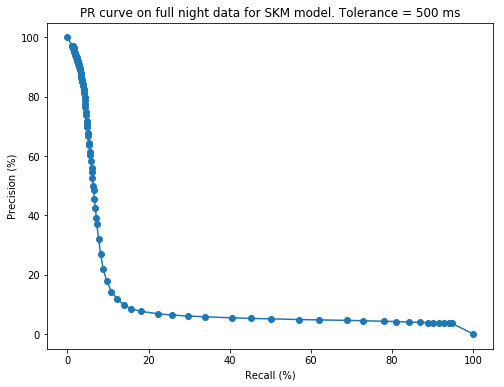

In [179]:
import soundfile as sf

unit_relevant = []
unit_selected, unit_tp = [], []
for unit_str in units:
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([model_name, tol_str, unit_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    precisions = np.array(df["precision (%)"])
    precisions = np.insert(precisions, 0, 0.0)
    precisions = np.append(precisions, 100)
    precisions = precisions[::-1] / 100
    recalls = np.array(df["recall (%)"])
    recalls = np.insert(recalls, 0, 100.0)
    recalls = np.append(recalls, 0.0)
    recalls = recalls[::-1] / 100
    auprc = np.trapz(precisions, recalls) * 100
    print(unit_str + ": AUPRC = " + ("%0.2f" % auprc).rjust(5) + "%")
    unit_relevant.append(np.array(df["relevant"])[0])
    unit_selected.append(np.array(df["selected"]))
    unit_tp.append(np.array(df["true positives"]))
    
relevant = np.sum(np.array(unit_relevant))
selected = np.sum(np.stack(unit_selected), axis=0)
tp = np.sum(np.stack(unit_tp), axis=0)
precisions = tp / selected
recalls = tp / relevant
precisions = np.insert(precisions, 0, min_precision)
precisions = np.append(precisions, 1.0)
precisions = precisions[::-1]
recalls = np.insert(recalls, 0, 1.0)
recalls = np.append(recalls, 0.0)
recalls = recalls[::-1]
auprc = np.trapz(precisions, recalls) * 100
print("")
print("Global: AUPRC = " + ("%0.2f" % auprc).rjust(5) + "%")

plt.figure(figsize=(8, 6))
plt.plot(100*recalls, 100*precisions, "-o")
plt.title("PR curve on full night data for SKM model. Tolerance = {} ms".format(tolerance_ms))
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")

unit01: AUPRC = 67.35%


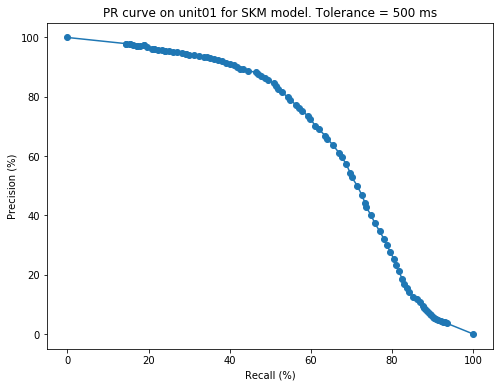

In [187]:
unit_str = "unit01"
unit_dir = os.path.join(model_dir, unit_str)
metrics_name = "_".join([model_name, tol_str, unit_str, "metrics"])
metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
df = pd.read_csv(metrics_path)
precisions = np.array(df["precision (%)"])
recalls = np.array(df["recall (%)"])
precisions = np.insert(precisions, 0, 0)
precisions = np.append(precisions, 100)
precisions = precisions[::-1] / 100
recalls = np.insert(recalls, 0, 100)
recalls = np.append(recalls, 0)
recalls = recalls[::-1] / 100
auprc = np.trapz(precisions, recalls) * 100
print(unit_str + ": AUPRC = " + ("%0.2f" % auprc).rjust(5) + "%")
unit_relevant.append(np.array(df["relevant"])[0])
unit_selected.append(np.array(df["selected"]))
unit_tp.append(np.array(df["true positives"]))
plt.figure(figsize=(8, 6))
plt.plot(100*recalls, 100*precisions, "-o")
plt.title("PR curve on {} for SKM model. Tolerance = {} ms".format(unit_str, tolerance_ms))
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")